## Visialization

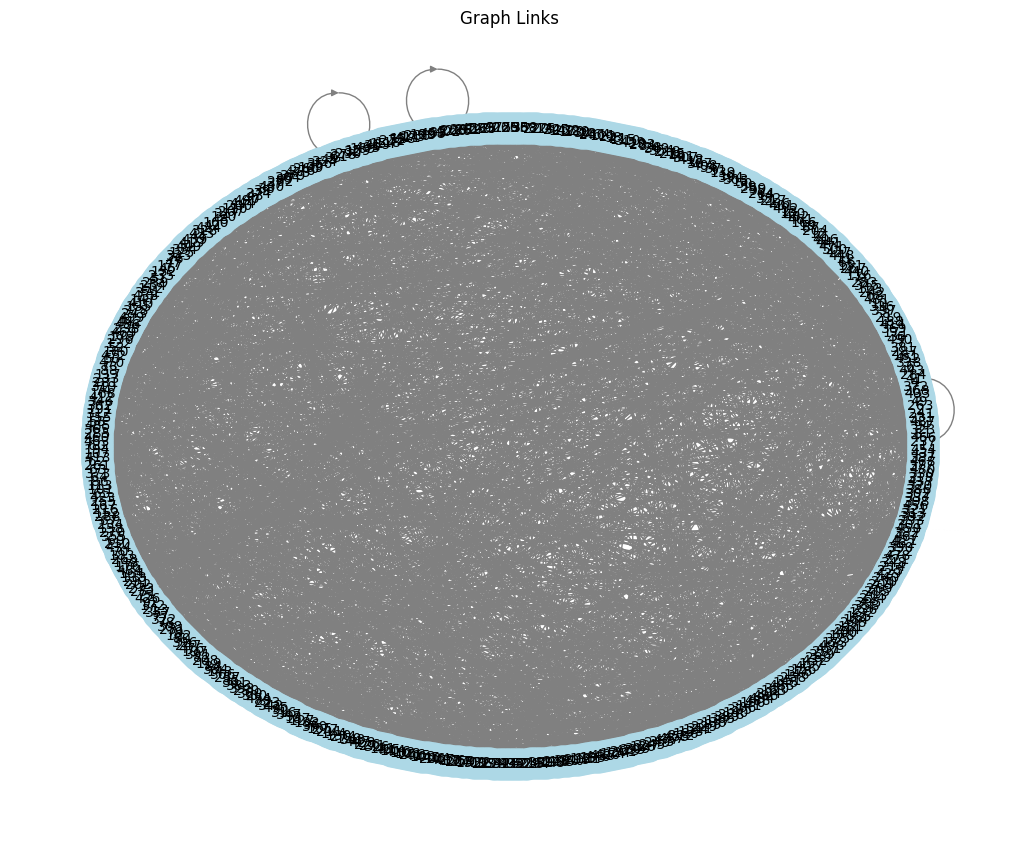

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

file_path = "Datasets/Graph_Links.txt"
graph = {}
with open(file_path, 'r') as file:
    for line in file:
        if ':' in line:
            node, links = line.strip().split(':')
            node = int(node)
            links = list(map(int, links.strip().split()))
            graph[node] = links

G = nx.DiGraph()
for node, links in graph.items():
    for link in links:
        G.add_edge(node, link)

plt.figure(figsize=(10, 8))
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=10, edge_color='gray', arrows=True)
plt.title("Graph Links")
plt.show()

## Dead-Ends

Dead-end nodes: [403, 492, 332, 295, 282, 5, 154, 419, 132, 243, 296, 234, 187, 274, 428, 226, 407, 389, 297, 468, 387]


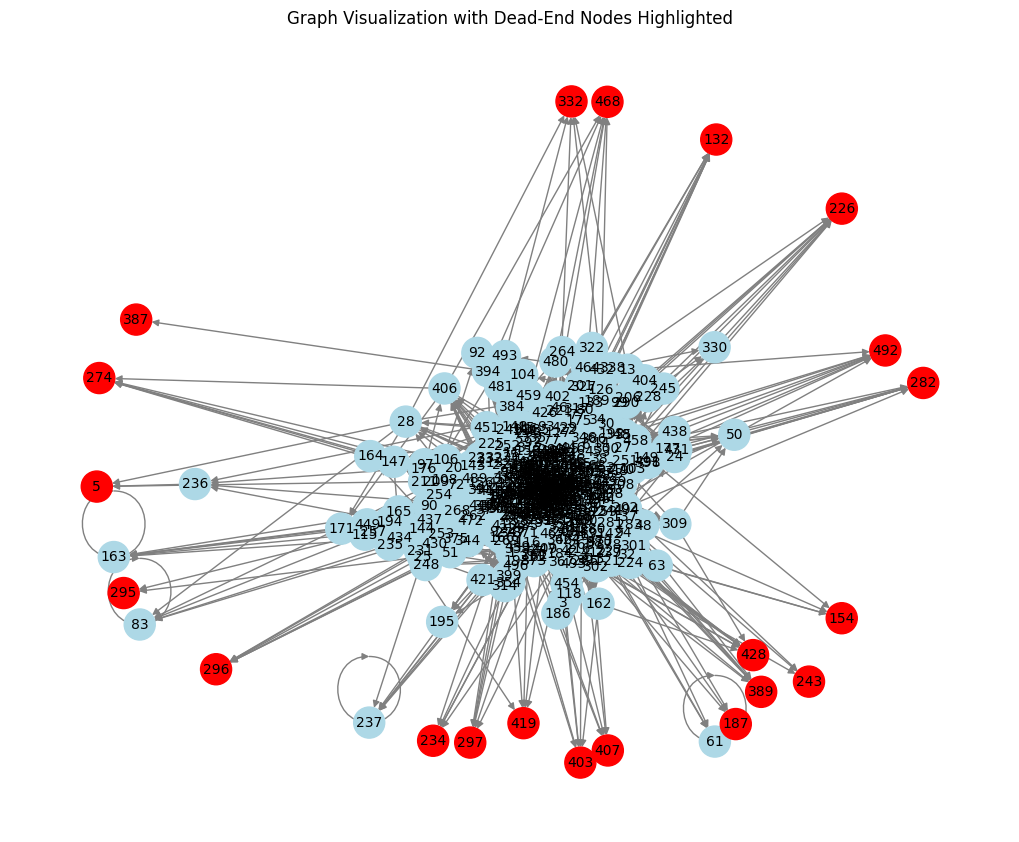

In [ ]:
# Find dead-end nodes
dead_end_nodes = [node for node in G.nodes() if G.out_degree(node) == 0]
print("Dead-end nodes:", dead_end_nodes)

# Plot the graph with dead-end nodes highlighted
node_colors = ['red' if node in dead_end_nodes else 'lightblue' for node in G.nodes()]

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=500, node_color=node_colors, font_size=10, edge_color='gray', arrows=True)
plt.title("Graph Visualization with Dead-End Nodes Highlighted")
plt.show()

## PageRank

In [ ]:
# Load Data
file_path = "Graph_Links.txt"
data = spark.read.text(file_path).rdd.map(lambda row: row[0])

# Parse Data into Adjacency List
def parse_line(line):
    parts = line.split(": ")
    node = int(parts[0])
    links = list(map(int, parts[1].split())) if len(parts) > 1 else []
    return node, links

edges = data.map(parse_line)
links = edges.mapValues(lambda links: set(links)).cache()

# Get all nodes
nodes = links.keys().union(links.flatMap(lambda x: x[1])).distinct()
N = nodes.count()

# Initialize PageRank
beta = 0.8
ranks = nodes.map(lambda node: (node, 1.0 / N))

# PageRank Iteration Function
def compute_contributions(node_links_rank):
    _, (links, rank) = node_links_rank
    num_links = len(links)
    if num_links == 0:
        return []
    contrib = rank / num_links
    return [(dest, contrib) for dest in links]

# Iterate until convergence
convergence_threshold = 0.001
converged = False

while not converged:
    contribs = links.join(ranks).flatMap(compute_contributions)
    
    # Calculate new ranks
    new_ranks = contribs.reduceByKey(lambda x, y: x + y).mapValues(lambda rank: beta * rank + (1 - beta) / N)
    
    # Compute difference
    delta = ranks.join(new_ranks).mapValues(lambda x: abs(x[0] - x[1])).values().max()
    
    ranks = new_ranks
    print("Delta:", delta)
    converged = delta < convergence_threshold

# Output results
print("Final PageRank Values:")
for node, rank in ranks.collect():
    print(f"Node {node}: {rank}")


Delta: 0.0035460317460317466
Delta: 0.0020759002267573697
Delta: 0.0015433102679096328
Delta: 0.0012970200294056726
Delta: 0.0010461097918616578
Delta: 0.0007637324387304838
Final PageRank Values:
Node 336: 0.0021227393017690947
Node 408: 0.001825388389825673
Node 200: 0.001732312450658645
Node 368: 0.001026613470545319
Node 360: 0.0015089211882527312
Node 352: 0.0030160229146922618
Node 376: 0.0020581759253697623
Node 136: 0.002296419264436296
Node 144: 0.0016534270898632866
Node 232: 0.0017809379042325122
Node 16: 0.0010643583049053573
Node 304: 0.0007866815463440707
Node 224: 0.0015504785356284987
Node 40: 0.0017706722005466715
Node 416: 0.0015521908289906573
Node 296: 0.0015635766417941709
Node 456: 0.0010415475127597868
Node 120: 0.0011402698217338823
Node 64: 0.0016330075846211903
Node 288: 0.0012810460454345171
Node 32: 0.002480519034707848
Node 392: 0.0012072677253006704
Node 256: 0.0016162982749074945
Node 176: 0.0017857543015683723
Node 112: 0.0018775682084859217
Node 96: 0.0

## HITS

In [ ]:
# Load Data
file_path = "Graph_Links.txt"
data = spark.read.text(file_path).rdd.map(lambda row: row[0])

# Parse Data into Adjacency List
def parse_line(line):
    parts = line.split(": ")
    node = int(parts[0])
    links = list(map(int, parts[1].split())) if len(parts) > 1 else []
    return node, links

edges = data.map(parse_line)
links = edges.mapValues(set).cache()

# Get all nodes
nodes = links.keys().union(links.flatMap(lambda x: x[1])).distinct()
N = nodes.count()

# Initialize Hubs and Authorities
hubs = nodes.map(lambda node: (node, 1.0))
authorities = nodes.map(lambda node: (node, 1.0))

# HITS Iteration Function
convergence_threshold = 0.05
converged = False
i = 0
while not converged:
    i += 1
    # Compute new authority scores: sum of hubs pointing to a node
    new_authorities = links.join(hubs).flatMap(lambda x: [(dest, x[1][1]) for dest in x[1][0]]) \
                           .reduceByKey(lambda x, y: x + y)

    # Compute new hub scores: sum of authorities of linked nodes
    new_hubs = links.join(authorities).flatMap(lambda x: [(x[0], x[1][1]) for _ in x[1][0]]) \
                    .reduceByKey(lambda x, y: x + y)

    # Normalize by setting max to 1
    max_auth = new_authorities.values().max()
    max_hub = new_hubs.values().max()
    
    new_authorities = new_authorities.mapValues(lambda v: v / max_auth if max_auth > 0 else 0)
    new_hubs = new_hubs.mapValues(lambda v: v / max_hub if max_hub > 0 else 0)

    # Compute difference for convergence
    delta_auth = authorities.join(new_authorities).mapValues(lambda x: abs(x[0] - x[1])).values().max()
    delta_hub = hubs.join(new_hubs).mapValues(lambda x: abs(x[0] - x[1])).values().max()

    hubs = new_hubs
    authorities = new_authorities
    print(f"i: {i}, Delta: {delta_auth + delta_hub}")
    converged = (delta_auth + delta_hub) < convergence_threshold

i: 1, Delta: 1.8230769230769233
i: 2, Delta: 1.5346441947565543
i: 3, Delta: 1.5176347462061752
i: 4, Delta: 0.3528753811480398
i: 5, Delta: 0.2775754778912005
i: 6, Delta: 0.19163101356628387
i: 7, Delta: 0.11671713760284574
i: 8, Delta: 0.08902341254564816
i: 9, Delta: 0.06322806779533607
i: 10, Delta: 0.040953947736565355
Final Hubs and Authorities Values:


PySparkRuntimeError: [PYTHON_HASH_SEED_NOT_SET] Randomness of hash of string should be disabled via PYTHONHASHSEED.

In [ ]:
auth_map = authorities.collectAsMap()
hub_map = hubs.collectAsMap()

for node, hub in hub_map.items():
    auth = auth_map.get(node, 0)
    print(f"Node {node}: Hub = {hub}, Authority = {auth}")

Node 12: Hub = 0.27278320630152186, Authority = 0.30765685495417094
Node 24: Hub = 0.07940933739439572, Authority = 0.7048000262044748
Node 36: Hub = 0.4725510985034841, Authority = 0.5267444326313117
Node 48: Hub = 0.17918427547367194, Authority = 0.321584176099179
Node 60: Hub = 0.3984913037274634, Authority = 0.5102080548060164
Node 72: Hub = 0.02978993396653227, Authority = 0.2672039991550187
Node 84: Hub = 0.5210606393983563, Authority = 0.46083611237394156
Node 96: Hub = 0.620536242474244, Authority = 0.5528626084403219
Node 108: Hub = 0.18449456690457838, Authority = 0.23177986901469858
Node 120: Hub = 0.22820439966476455, Authority = 0.20220979461021907
Node 144: Hub = 0.2945994674800094, Authority = 0.4365728585627408
Node 156: Hub = 0.032976573252578294, Authority = 0.29665622846494016
Node 168: Hub = 0.5599841141071886, Authority = 0.6225181932570059
Node 180: Hub = 0.14891995000429112, Authority = 0.6626960510345701
Node 192: Hub = 0.09052608510925353, Authority = 0.2027072

In [ ]:
import pandas as pd

# page_rank_dict = dict(ranks.collect())
# Create Pandas DataFrame
df = pd.DataFrame({
    "Node": list(page_rank_dict.keys()),
    "PageRank": list(page_rank_dict.values()),
    "Hubs": [hub_map.get(node, 0.0) for node in page_rank_dict.keys()],
    "Authorities": [auth_map.get(node, 0.0) for node in page_rank_dict.keys()]
})

# Save as CSV
output_path = "Datasets/PageRank_HITS.csv"
df.to_csv(output_path, index=False)

print(f"Results saved to {output_path}")


Results saved to Datasets/PageRank_HITS.csv
